## Equity for Minneapolis

## Issues
1. [fixed] negative improvemnt results means dockless sometimes counts fewer jobs than plt


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# Load in the accessibility results
filepath = '/Users/askalila/Documents/GitHub/32_wri_numo/data/Minneapolis/level_i_ii/accessibility_results.geojson'
access = gpd.read_file(filepath)

# Load population files
filepath2 = '/Users/askalila/Documents/GitHub/32_wri_numo/data/Minneapolis/level_i_ii/zones_w_micromobility_providers.geojson'
zones = gpd.read_file(filepath2)

total_jobs = zones.C000.sum()

In [11]:
# ensure the array of accessibility values is sorted from lowest to highest values first!
access_pt = np.sort(list(access.jobs_tt_pt_60))
access_pt_docked = np.sort(list(access.jobs_tt_docked_service_60))
access_pt_dockless = np.sort(list(access.jobs_tt_dockless_service_60))
access_pt_bestMM = np.sort(list(access.jobs_tt_docked_dockless_best_60))


In [5]:

def gini(arr):
    count = arr.size
    coefficient = 2. / count
    indexes = np.arange(1., count + 1)
    weighted_sum = np.nansum(indexes * arr)
    total = np.nansum(arr)
    constant = (count + 1.) / count
    return coefficient * weighted_sum / total - constant

def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = np.nancumsum(arr) / np.nansum(arr) *100
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)


In [12]:
# show the gini index for PT 
print('Gini Index with only Public Transport: \t\t',np.round(gini(access_pt),4))
print('Gini Index with Public Transport + docked MM:\t',np.round(gini(access_pt_docked),4))
print('Gini Index with Public Transport + dockless MM:\t',np.round(gini(access_pt_dockless),4))
print('Gini Index with Public Transport + best MM:\t',np.round(gini(access_pt_bestMM),4))

Gini Index with only Public Transport: 		 0.6431
Gini Index with Public Transport + docked MM:	 0.6692
Gini Index with Public Transport + dockless MM:	 0.6378
Gini Index with Public Transport + best MM:	 0.6371


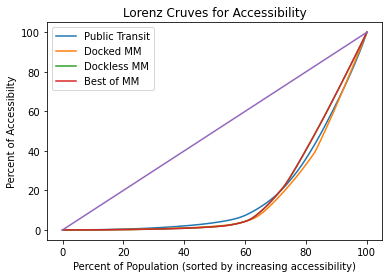

In [14]:
lorenz_curve_pt = lorenz(access_pt)
lorenz_curve_pt_docked = lorenz(access_pt_docked)
lorenz_curve_pt_docless = lorenz(access_pt_dockless)
lorenz_curve_pt_2 = lorenz(access_pt_bestMM)


# we need the X values to be between 0.0 to 1.0
plt.plot(np.linspace(0.0, 100, lorenz_curve_pt.size), lorenz_curve_pt, label = "Public Transit")
plt.plot(np.linspace(0.0, 100, lorenz_curve_pt_docked.size), lorenz_curve_pt_docked, label = "Docked MM")
plt.plot(np.linspace(0.0, 100, lorenz_curve_pt_docless.size), lorenz_curve_pt_docless, label = "Dockless MM")
plt.plot(np.linspace(0.0, 100, lorenz_curve_pt_2.size), lorenz_curve_pt_2, label = "Best of MM")
plt.legend(loc="upper left")
# plot the straight line perfect equality curve

plt.plot([0,100], [0,100])
plt.title("Lorenz Cruves for Accessibility")
plt.xlabel("Percent of Population (sorted by increasing accessibility)")
plt.ylabel("Percent of Accessibilty")
plt.savefig('Lorenz_curve_MN.png')
plt.show()

In [ ]:
access.jobs

## Improvement

In [23]:
access['jobs_tt_docked_dockless_best_60'] = access['jobs_tt_docked_dockless_best_60']*total_jobs/100


In [18]:
access['jobs_tt_improve_dock_dockless_pt_60'] = access['jobs_tt_improve_dock_dockless_pt_60']*total_jobs/100
access['jobs_tt_pt_60'] = access['jobs_tt_pt_60']*total_jobs/100

access['jobs_tt_improve_dock_dockless_pt_60'].describe()

count      3931.000000
mean     143947.598314
std      200672.823562
min           0.000000
25%           0.000000
50%         669.999742
75%      342224.999360
max      711206.999719
Name: jobs_tt_improve_dock_dockless_pt_60, dtype: float64

array([[<AxesSubplot:title={'center':'jobs_tt_improve_dock_dockless_pt_60'}>]],
      dtype=object)

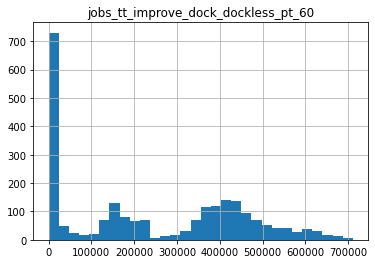

In [19]:
access[access.jobs_tt_improve_dock_dockless_pt_60 > 0].hist(column='jobs_tt_improve_dock_dockless_pt_60', bins = 30)

In [32]:
# Calculate Improvement by population group 
improvement = access[['cell_id','jobs_tt_improve_dock_dockless_pt_60', 'jobs_tt_pt_60','jobs_tt_docked_dockless_best_60']]
zones_short = zones[['cell_id', 'pop_totalE', 'pop_whiteE', 'pop_blackE',
       'pop_american_indianE', 'pop_asianE', 'pop_hawaiianE',
       'pop_other_raceE', 'pop_other_two_racesE', 'income_0.9999E',
       'income_10000.14999E', 'income_15000.29999E', 'income_20000.24999E',
       'income_25000.29999E', 'income_30000.34999E', 'income_35000.39999E',
       'income_40000.44999E', 'income_44000.49999E', 'income_50000.59999E',
       'income_60000.74999E', 'income_75000.99999E', 'income_100000.124999E',
       'income_125000.149999E', 'income_150000.199999E', 'income_above.200000E']]

improvement = pd.merge(improvement, zones_short, on='cell_id',how='inner')


### Weighed average accessibilty by population group

In [28]:
# average weighted accessibility for PT and MM

pop_groups =['pop_totalE', 'pop_whiteE', 'pop_blackE',
       'pop_american_indianE', 'pop_asianE', 'pop_hawaiianE',
       'pop_other_raceE', 'pop_other_two_racesE']

pop_access = dict()

for group in pop_groups:
    for mode in ['jobs_tt_pt_60','jobs_tt_docked_dockless_best_60','jobs_tt_improve_dock_dockless_pt_60']:
       
       product = improvement[mode]*improvement[group]
       group_access = np.round(product.sum()/improvement[group].sum(),0)

       pop_access[mode[8:]+'_'+ group[4:-1]] = group_access
       print(f'Total {group} access for {mode}:\t\t {group_access}')
        
       if 'improve' in mode: print('\n')

Total pop_totalE access for jobs_tt_pt_60:		 59189.0
Total pop_totalE access for jobs_tt_docked_dockless_best_60:		 156837.0
Total pop_totalE access for jobs_tt_improve_dock_dockless_pt_60:		 97774.0


Total pop_whiteE access for jobs_tt_pt_60:		 49726.0
Total pop_whiteE access for jobs_tt_docked_dockless_best_60:		 137086.0
Total pop_whiteE access for jobs_tt_improve_dock_dockless_pt_60:		 87477.0


Total pop_blackE access for jobs_tt_pt_60:		 104792.0
Total pop_blackE access for jobs_tt_docked_dockless_best_60:		 260828.0
Total pop_blackE access for jobs_tt_improve_dock_dockless_pt_60:		 156175.0


Total pop_american_indianE access for jobs_tt_pt_60:		 126607.0
Total pop_american_indianE access for jobs_tt_docked_dockless_best_60:		 315632.0
Total pop_american_indianE access for jobs_tt_improve_dock_dockless_pt_60:		 189137.0


Total pop_asianE access for jobs_tt_pt_60:		 60684.0
Total pop_asianE access for jobs_tt_docked_dockless_best_60:		 140749.0
Total pop_asianE access for jobs_

### Weighted Average Accessibility by Income Group

In [47]:
pop_groups =['income_0.9999E',
       'income_10000.14999E', 'income_15000.29999E', 'income_20000.24999E',
       'income_25000.29999E', 'income_30000.34999E', 'income_35000.39999E',
       'income_40000.44999E', 'income_44000.49999E', 'income_50000.59999E',
       'income_60000.74999E', 'income_75000.99999E', 'income_100000.124999E',
       'income_125000.149999E', 'income_150000.199999E','income_above.200000E']

zones['pop_income'] = zones[pop_groups].sum(axis=1)

In [49]:
# average weighted accessibility for PT and MM

pop_groups =['pop_income','income_0.9999E',
       'income_10000.14999E', 'income_15000.29999E', 'income_20000.24999E',
       'income_25000.29999E', 'income_30000.34999E', 'income_35000.39999E',
       'income_40000.44999E', 'income_44000.49999E', 'income_50000.59999E',
       'income_60000.74999E', 'income_75000.99999E', 'income_100000.124999E',
       'income_125000.149999E', 'income_150000.199999E','income_above.200000E']

pop_access_income = dict()

for group in pop_groups:
    for mode in ['jobs_tt_pt_60','jobs_tt_docked_dockless_best_60','jobs_tt_improve_dock_dockless_pt_60']:
       
       product = improvement[mode]*zones[group]
       group_access = np.round(product.sum()/zones[group].sum(),0)

       pop_access_income[mode[8:]+'_'+ group[4:-1]] = group_access
       print(f'Total {group} access for {mode}:\t\t {group_access}')
        
       if 'improve' in mode: print('\n')

Total pop_income access for jobs_tt_pt_60:		 63519.0
Total pop_income access for jobs_tt_docked_dockless_best_60:		 168359.0
Total pop_income access for jobs_tt_improve_dock_dockless_pt_60:		 104951.0


Total income_0.9999E access for jobs_tt_pt_60:		 118991.0
Total income_0.9999E access for jobs_tt_docked_dockless_best_60:		 290249.0
Total income_0.9999E access for jobs_tt_improve_dock_dockless_pt_60:		 171400.0


Total income_10000.14999E access for jobs_tt_pt_60:		 113913.0
Total income_10000.14999E access for jobs_tt_docked_dockless_best_60:		 273950.0
Total income_10000.14999E access for jobs_tt_improve_dock_dockless_pt_60:		 160139.0


Total income_15000.29999E access for jobs_tt_pt_60:		 95809.0
Total income_15000.29999E access for jobs_tt_docked_dockless_best_60:		 236966.0
Total income_15000.29999E access for jobs_tt_improve_dock_dockless_pt_60:		 141310.0


Total income_20000.24999E access for jobs_tt_pt_60:		 87412.0
Total income_20000.24999E access for jobs_tt_docked_dockle